# Regression fairness measures demo


Copyright 2023 Gradient Institute

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


## Setup

In [1]:
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# Settings
sns.set(context='notebook', style="white", font_scale=1.6)
sns.despine()
p_a = 0.7  # p(a = 1)
N = 1000  # size of dataset
gamma = 0.08  # kernel bandwidth
components = 2000  # kernel samples

# freeze random state
RS = 666
rand = np.random.RandomState(RS)

# dataframe helper
def make_df(y, s, a):
    df = pd.DataFrame({'Y': y, 'S': s, 'A': a})
    return df

<Figure size 640x480 with 0 Axes>

In [2]:
# Generate the sensitive attribute
def gen_sensitive(N, p_a):
    a = rand.binomial(n=1, p=p_a, size=N)
    return a

a = gen_sensitive(N, p_a)

## Classifiers

In [3]:
# Classifier
from sklearn.linear_model import LogisticRegression
from sklearn.kernel_approximation import RBFSampler
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import balanced_accuracy_score, log_loss
from sklearn.pipeline import make_pipeline

# Consistent Fold splitting
cv = KFold(n_splits=10, shuffle=True)
splits = list(cv.split(a))


# Validate classifier, get held-out predictions, refit on all data
def class_pred(X, Y, n_components=50, gamma=1., name=""):
    # Instantiate classifier
    clf = make_pipeline(
        RBFSampler(n_components=n_components, gamma=gamma, random_state=RS),
        LogisticRegression(solver="lbfgs")
    )
    
    # Cross val predictions
    p = cross_val_predict(clf, X, a, method="predict_proba", cv=splits)
    
    # Scores
    ll = log_loss(a, p)
    acc = balanced_accuracy_score(a, p[:, 1] > 0.5)
    print(f"{name} classifier log loss {ll:.4f}, balanced accuracy {acc:.4f}")
    
    # Re-fit
    clf.fit(X, Y)
    #p = clf.predict_proba(X)
    return p, clf


def make_classifiers(df, n_components=components, gamma=1.):
    pa_1 = np.mean(df['A'])
    p_a = np.repeat([[1 - pa_1, pa_1]], len(df), axis=0)
    p_y, clf_y = class_pred(df[['Y']].values, df['A'], n_components, gamma, "P(A|Y)")
    p_s, clf_s = class_pred(df[['S']].values, df['A'], n_components, gamma, "P(A|S)")
    p_sy, clf_sy = class_pred(df[['S', 'Y']].values, df['A'], n_components, gamma, "P(A|S, Y)")
    clf_dict = {
        "PY": clf_y.fit(df[['Y']].values, df['A']),
        "PS": clf_s.fit(df[['S']].values, df['A']),
        "PSY": clf_sy.fit(df[['S', 'Y']].values, df['A'])
    }
    return p_a, p_y, p_s, p_sy, clf_dict

## Compute measures

In [4]:
from fastfair import measures

def compute_mi_measures(p_a, p_y, p_s, p_sy, a=None, normalise=True):
    ind = measures.cmi(p_s, p_a, a, normalise)
    sep = measures.cmi(p_sy, p_y, a, normalise)
    suf = measures.cmi(p_sy, p_s, a, normalise)
    est_type = "est" if a is None else "emp"
    print(f"NMI {est_type} -- Ind: {ind:.4f}, Sep: {sep:.4f}, Suf: {suf:.4f}")
    return ind, sep, suf

def compute_er_measures(p_a, p_y, p_s, p_sy):
    ind = measures.ratio(p_s, p_a)
    sep = measures.ratio(p_sy, p_y)
    suf = measures.ratio(p_sy, p_s)
    print(f"E[r] -- Ind: {ind:.4f}, Sep: {sep:.4f}, Suf: {suf:.4f}")
    return ind, sep, suf

## Plotting

In [5]:
def make_joint(df, clf, xlim=[-15, 15], ylim=[-15, 15], cmap="RdBu_r"):
    # Make the joint axes
    grid = sns.JointGrid(x='Y', y='S', data=df, space=.1, height=9, xlim=xlim, ylim=ylim)

    # Add scatter
    grid.plot_joint(sns.scatterplot, hue='A', data=df, alpha=0.7, palette=cmap)
    
    # Classifier probabilities - joint SY
    s, y = np.linspace(*ylim, 200), np.linspace(*xlim, 200)
    S, Y = np.meshgrid(s, y)
    sy = np.hstack((np.reshape(S, [200*200, 1]), np.reshape(Y, [200*200, 1])))
    p = clf["PSY"].predict_proba(sy)[:, 1]
    P = np.reshape(p, [200, 200])
    with plt.style.context("seaborn-white"):
        cs = grid.ax_joint.contour(Y, S, P, zorder=0, levels=5, cmap=cmap)
        plt.clabel(cs, inline=1, fontsize=12)
        
    cols = matplotlib.cm.get_cmap(cmap)
    
    # Marginal density - Y
    sns.kdeplot(df.loc[df['A']==1, 'Y'], ax=grid.ax_marg_x, legend=False, color=cols(.9), fill=True)
    sns.kdeplot(df.loc[df['A']==0, 'Y'], ax=grid.ax_marg_x, legend=False, color=cols(.1), fill=True)
    p = clf["PY"].predict_proba(y[:, np.newaxis])[:, 1]
    with plt.style.context("seaborn-white"):
        grid.ax_marg_x.scatter(y, np.zeros_like(y), c=p, marker='s', cmap=cmap, alpha=0.2, edgecolors='none',
                              s=70)
        grid.ax_marg_x.set_title("$\mathrm{P}(Y|A)$")
    
    # Marginal density - S
    sns.kdeplot(df.loc[df['A']==1, ['S']], y="S", ax=grid.ax_marg_y, legend=False, color=cols(.9), fill=True)
    sns.kdeplot(df.loc[df['A']==0, ['S']], y="S", ax=grid.ax_marg_y, legend=False, color=cols(.1), fill=True)
    p = clf["PS"].predict_proba(y[:, np.newaxis])[:, 1]
    with plt.style.context("seaborn-white"):
        grid.ax_marg_y.scatter(np.zeros_like(s), s, c=p, marker='s', cmap=cmap, alpha=0.2, 
                               edgecolors='none', s=70)
        grid.ax_marg_y.set_title("$\mathrm{P}(S|A)$")
    
    return grid

## Linear S-Y relationships

In [6]:
def gen_linear(a, sigma0=1.5, sigma1=1.5, mu_s_0=0., mu_s_1=0., mu_y_0=0., mu_y_1=0.):
    ymin = -10
    ymax = 10
    N0 = sum(a==0)
    N1 = N - N0
    y = rand.uniform(low=ymin, high=ymax, size=N)
    s = y.copy()
    s[a==1] += mu_s_1 + rand.randn(N1) * sigma1
    s[a==0] += mu_s_0 + rand.randn(N0) * sigma0
    y[a==1] += mu_y_1
    y[a==0] += mu_y_0
    df = make_df(y, s, a)
    return df

### Same noise

P(A|Y) classifier log loss 0.6085, balanced accuracy 0.5000
P(A|S) classifier log loss 0.6106, balanced accuracy 0.5000
P(A|S, Y) classifier log loss 0.6116, balanced accuracy 0.5017
NMI est -- Ind: 0.0087, Sep: 0.0053, Suf: 0.0054
NMI emp -- Ind: -0.0081, Sep: -0.0050, Suf: -0.0016
E[r] -- Ind: 1.0401, Sep: 1.0267, Suf: 1.0199


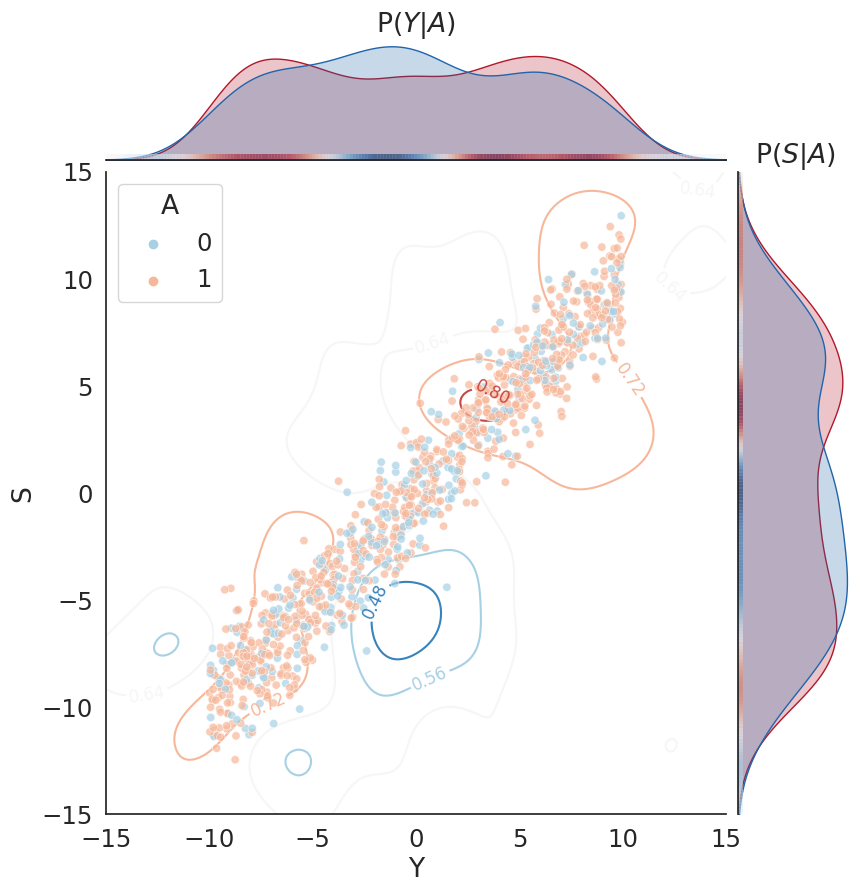

In [7]:
df_linear = gen_linear(a)
p_a, p_y, p_s, p_sy, clf_dict = make_classifiers(df_linear, gamma=gamma)
compute_mi_measures(p_a, p_y, p_s, p_sy)
compute_mi_measures(p_a, p_y, p_s, p_sy, a)
compute_er_measures(p_a, p_y, p_s, p_sy)
make_joint(df_linear, clf_dict)
plt.savefig("fair.png", dpi=300)

### Different score mean

P(A|Y) classifier log loss 0.6097, balanced accuracy 0.5000
P(A|S) classifier log loss 0.4416, balanced accuracy 0.6556
P(A|S, Y) classifier log loss 0.0678, balanced accuracy 0.9908
NMI est -- Ind: 0.2300, Sep: 0.6781, Suf: 0.6015
NMI emp -- Ind: 0.2709, Sep: 0.8888, Suf: 0.8465
E[r] -- Ind: 4.4771, Sep: 9.7016, Suf: 6.6931


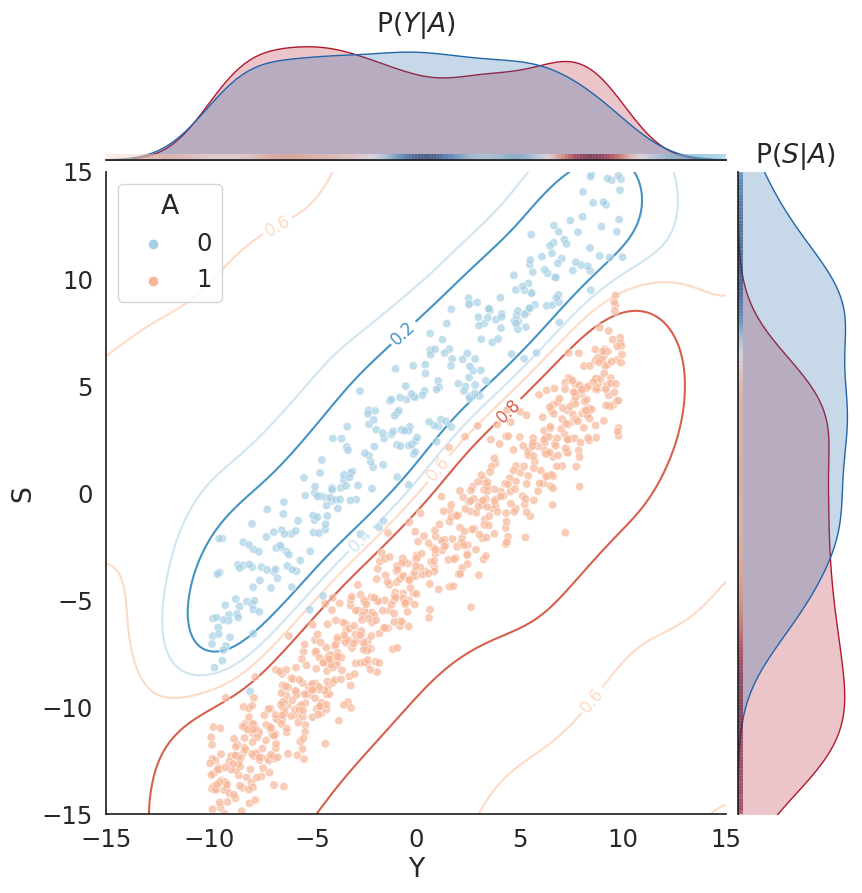

In [8]:
df_linear = gen_linear(a, mu_s_0=4, mu_s_1=-4)
p_a, p_y, p_s, p_sy, clf_dict = make_classifiers(df_linear, gamma=gamma)
compute_mi_measures(p_a, p_y, p_s, p_sy)
compute_mi_measures(p_a, p_y, p_s, p_sy, a)
compute_er_measures(p_a, p_y, p_s, p_sy)
make_joint(df_linear, clf_dict)
plt.savefig("s_mean_diff.png", dpi=300)

### Different target mean

P(A|Y) classifier log loss 0.3952, balanced accuracy 0.6851
P(A|S) classifier log loss 0.6139, balanced accuracy 0.5000
P(A|S, Y) classifier log loss 0.0638, balanced accuracy 0.9911
NMI est -- Ind: 0.0024, Sep: 0.5918, Suf: 0.6888
NMI emp -- Ind: -0.0136, Sep: 0.8387, Suf: 0.8961
E[r] -- Ind: 1.0069, Sep: 6.3079, Suf: 9.9778


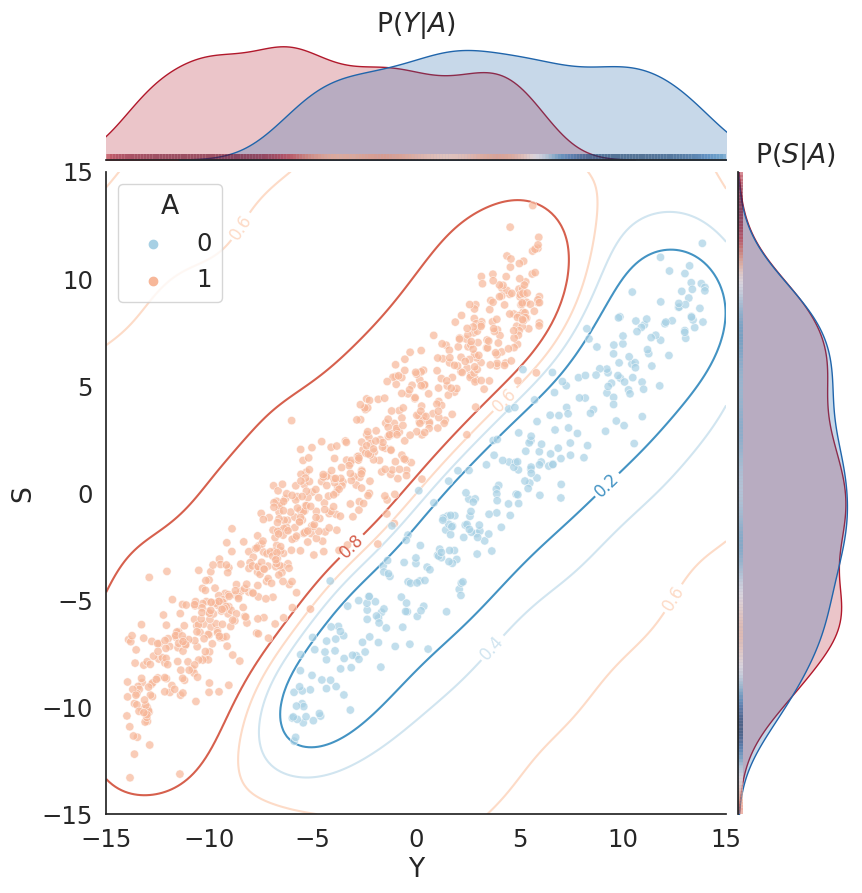

In [9]:
df_linear = gen_linear(a, mu_y_0=4, mu_y_1=-4)
p_a, p_y, p_s, p_sy, clf_dict = make_classifiers(df_linear, gamma=gamma)
compute_mi_measures(p_a, p_y, p_s, p_sy)
compute_mi_measures(p_a, p_y, p_s, p_sy, a)
compute_er_measures(p_a, p_y, p_s, p_sy)
make_joint(df_linear, clf_dict)
plt.savefig("y_mean_diff.png", dpi=300)

### Different class noise

P(A|Y) classifier log loss 0.6125, balanced accuracy 0.5000
P(A|S) classifier log loss 0.5549, balanced accuracy 0.5914
P(A|S, Y) classifier log loss 0.4125, balanced accuracy 0.7564
NMI est -- Ind: 0.0688, Sep: 0.2202, Suf: 0.1618
NMI emp -- Ind: 0.0838, Sep: 0.3266, Suf: 0.2568
E[r] -- Ind: 1.1673, Sep: 1.7339, Suf: 1.4921


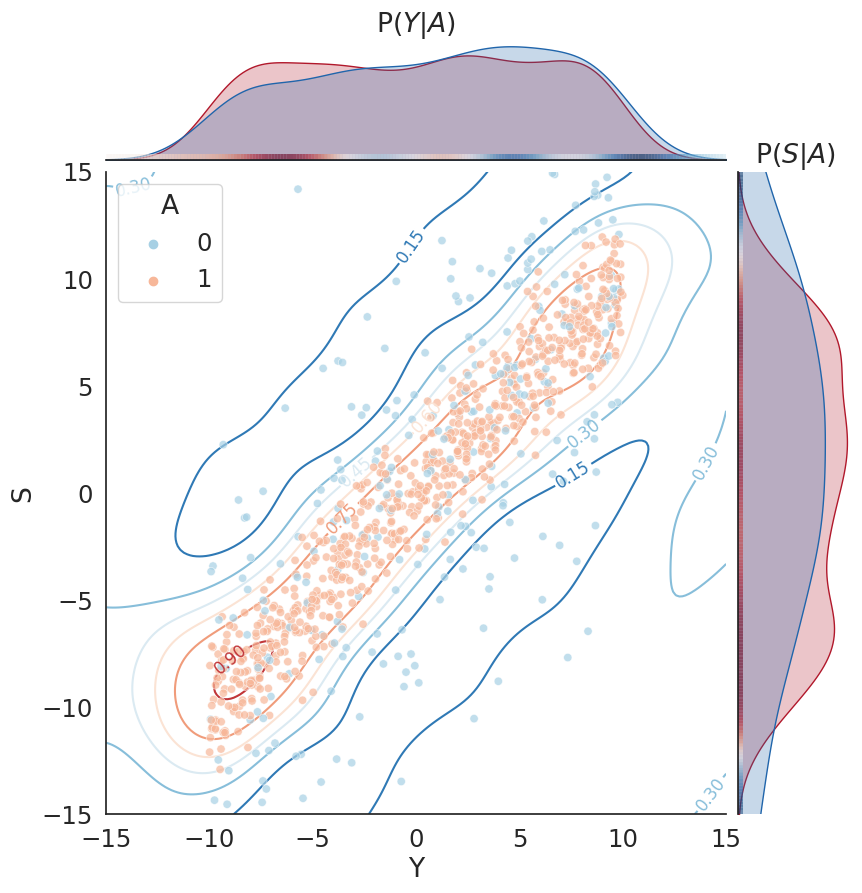

In [10]:
df_linear = gen_linear(a, sigma0=6.)
p_a, p_y, p_s, p_sy, clf_dict = make_classifiers(df_linear, gamma=gamma)
compute_mi_measures(p_a, p_y, p_s, p_sy)
compute_mi_measures(p_a, p_y, p_s, p_sy, a)
compute_er_measures(p_a, p_y, p_s, p_sy)
make_joint(df_linear, clf_dict)
plt.savefig("variance.png", dpi=300)